In [1]:
import sys
sys.path.insert(0, '../../utils/')

In [20]:
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

%matplotlib inline
mpl.rcParams['figure.dpi']= 500
sns.set_context("notebook")
sns.set(style="white")
plt.rcParams['font.family'] = 'Myriad Pro'

In [3]:
from cellvgae import mean_of_attention_heads

In [4]:
LATENT_DIM = 50
ATTN_HEADS = 16

In [5]:
cellvgae_node_embs = np.load('PBMC3k/CellVGAE/cellvgae_node_embs.npy')
cellvgae_umap = np.load('PBMC3k/CellVGAE/cellvgae_umap.npy')
cellvgae_clusters = np.load('PBMC3k/CellVGAE/cellvgae_clusters.npy')

In [6]:
layer_1_attn_edge_index = torch.load('PBMC3k/attn_layers_data/pbmc3k_hidden_layer_1_attention_edge_index.pt')
layer_1_attn_coeff = torch.load('PBMC3k/attn_layers_data/pbmc3k_hidden_layer_1_attention_coeff.pt')

In [7]:
layer_2_attn_edge_index = torch.load('PBMC3k/attn_layers_data/pbmc3k_hidden_layer_2_attention_edge_index.pt')
layer_2_attn_coeff = torch.load('PBMC3k/attn_layers_data/pbmc3k_hidden_layer_2_attention_coeff.pt')

In [8]:
layer_mean_attn_edge_index = torch.load('PBMC3k/attn_layers_data/pbmc3k_hidden_layer_mean_attention_edge_index.pt')
layer_mean_attn_coeff = torch.load('PBMC3k/attn_layers_data/pbmc3k_hidden_layer_mean_attention_coeff.pt')

In [9]:
layer_std_attn_edge_index = torch.load('PBMC3k/attn_layers_data/pbmc3k_hidden_layer_std_attention_edge_index.pt')
layer_std_attn_coeff = torch.load('PBMC3k/attn_layers_data/pbmc3k_hidden_layer_std_attention_coeff.pt')

In [10]:
seurat_df = pd.read_csv('PBMC3k/seurat_clusters.csv')

In [11]:
cell_types = seurat_df['Cluster'].values.tolist()

In [12]:
num_cells = len(cell_types)

In [13]:
def get_cell_weights_for_layer(layer_edge_index, layer_coeff):
    cell_weights = []
    for dim in range(0, ATTN_HEADS):
        cell_weights_dim = []
        for cell_id in range(num_cells):
            dim0 = layer_edge_index[0] == cell_id
            dim1 = layer_edge_index[1] == cell_id
            idxs = torch.logical_or(dim0, dim1)
            cell_weight = torch.sum(layer_coeff[idxs, dim])
            cell_weights_dim.append(cell_weight.detach().numpy())
        cell_weights.append(cell_weights_dim)
    return np.array(cell_weights)

In [74]:
second_layer_cell_weights = get_cell_weights_for_layer(layer_2_attn_edge_index, layer_2_attn_coeff)

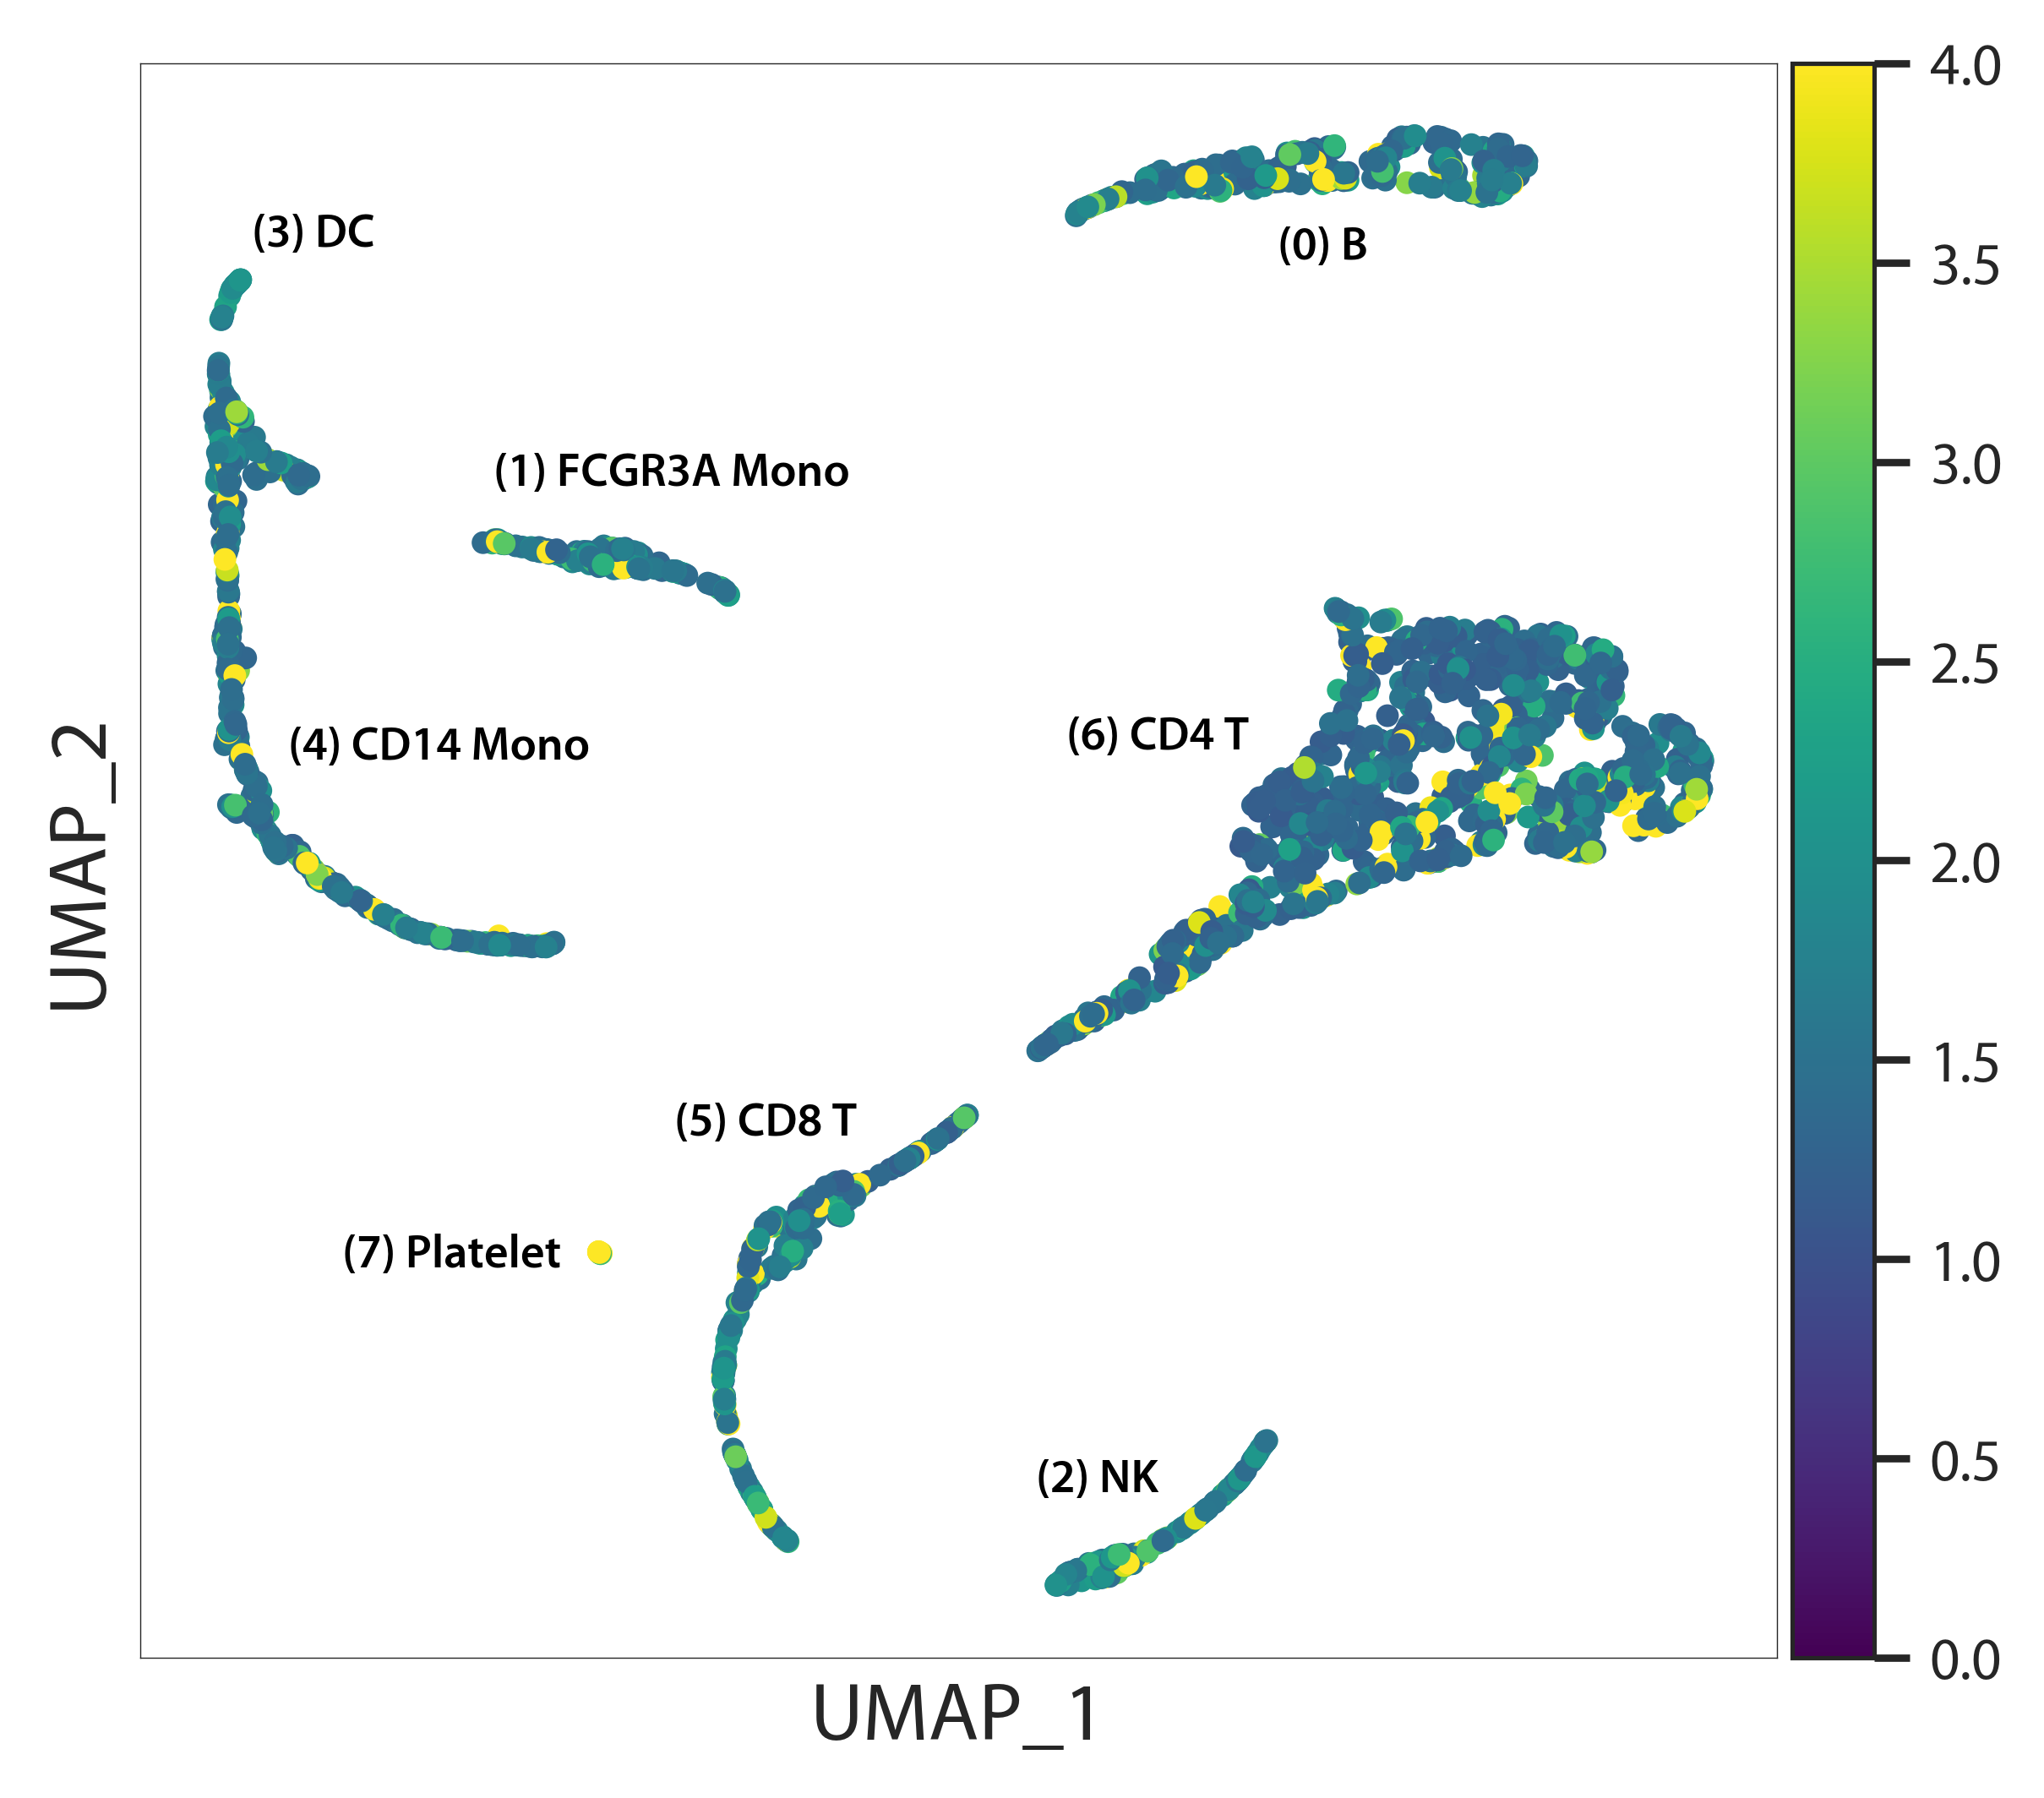

In [101]:
plt.figure(figsize=(5, 5))
plt.tight_layout()
ax = sns.scatterplot(x=cellvgae_umap[:, 0], y=cellvgae_umap[:, 1], hue=np.mean(second_layer_cell_weights, axis=0), hue_norm=(0, 4), palette="viridis", s=15, edgecolor='black', linewidth=0.0)

ax.get_legend().remove()

norm = plt.Normalize(0, 4)
axins = inset_axes(ax,
        width='5%',  
        height='100%',
        loc='center right',
        borderpad=-1.5
       )
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, cax=axins, pad=0.2)
cbar.ax.tick_params(labelsize=6)
cbar.outline.set_linewidth(0.75)
cbar.ax.tick_params(labelsize=10) 

ax.spines['left'].set_linewidth(0.2)
ax.spines['top'].set_linewidth(0.2)
ax.spines['bottom'].set_linewidth(0.2)
ax.spines['right'].set_linewidth(0.2)

ax.text(6, -7, "(2) NK", horizontalalignment='left', size='8', color='black', weight='semibold')
ax.text(0, 0.3, "(5) CD8 T", horizontalalignment='left', size='8', color='black', weight='semibold')
ax.text(-5.5, -2.4, "(7) Platelet", horizontalalignment='left', size='8', color='black', weight='semibold')
ax.text(6.5, 8.2, "(6) CD4 T", horizontalalignment='left', size='8', color='black', weight='semibold')
ax.text(10, 18.25, "(0) B", horizontalalignment='left', size='8', color='black', weight='semibold')
ax.text(-3, 13.6, "(1) FCGR3A Mono", horizontalalignment='left', size='8', color='black', weight='semibold')
ax.text(-6.4, 8, "(4) CD14 Mono", horizontalalignment='left', size='8', color='black', weight='semibold')
ax.text(-7, 18.5, "(3) DC", horizontalalignment='left', size='8', color='black', weight='semibold')

plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.set_xlabel('UMAP_1', fontsize=14)
ax.set_ylabel('UMAP_2', fontsize=14)

plt.savefig('pbmc3k_umap_layer_2_mean.pdf', dpi=350, bbox_inches='tight')